In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('..')
from preprocessing.input_data_index_embedding import *

from preprocessing.preprocessing_code_190418 import title_catcher, preprocess, date_process
import pickle as pkl
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score
from sklearn.metrics import classification_report

from collections import Counter
from konlpy.tag import Komoran
from eunjeon import Mecab
mecab = Mecab()

from keras.preprocessing.sequence import pad_sequences


Using TensorFlow backend.


In [2]:
import keras
import matplotlib.pyplot as plt
from keras.layers import Input, Embedding, Dense, LSTM, Bidirectional, Dropout, Concatenate, Flatten, Conv1D, Conv2D, GlobalMaxPooling1D, TimeDistributed, SpatialDropout1D, GRU, multiply, Lambda, Reshape, CuDNNGRU, CuDNNLSTM, Permute, RepeatVector, Multiply
from keras.layers import MaxPool1D
from keras.models import Model, Sequential
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.engine.topology import Layer
from keras.preprocessing.sequence import pad_sequences
from keras_self_attention import SeqSelfAttention
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
import seaborn as sn

# Data Import

In [3]:
data_dir = '../data/191203_인수계약서_최종.xlsx'
vocab_to_int_dir = '../preprocessing/insu_vocab_to_int.pkl'
int_to_vocab_dir = '../preprocessing/insu_int_to_vocab.pkl'

In [4]:
with open('./par_model/train_probability.pickle', 'rb') as f:
    train_prob = pickle.load(f)
with open('./par_model/valid_probability.pickle', 'rb') as f:
    valid_prob = pickle.load(f)
with open('./par_model/test_probability.pickle', 'rb') as f:
    test_prob = pickle.load(f)

In [5]:
origin_data = load_dataset(data_dir)
origin_data = join_date(origin_data)
origin_data.head(3)

,doc_id,par_id,art_id,line_id,text,par_label,line_label,split_id
0,22,2,1,0,제1조 (정의),정의,-,22_정의
1,22,2,1,1,본 계약에서 사용하는 용어는 다음과 같은 뜻을 가진다.,정의,PR-02-01,22_정의
2,22,2,1,2,"1. ""인수단""은 ""대표주관회사"" 및 ""인수회사""를 말한다.",정의,PR-02-02,22_정의


# Document to paragraph

In [6]:
ptl_df = document_label_dataset_training(origin_data)
ptl_df.head(3)

,index,doc,label,line_label
0,0,0 ...,정의,"[-, PR-02-01, PR-02-02, PR-02-03, PR-02-04, PR..."
1,1,19 제2조 ...,인수_및_모집,"[-, PR-03-01, PR-03-02, PR-03-02, PR-03-02, PR..."
2,2,"32 제3조 (""본 사...",본_사채의_발행조건,"[-, PR-04-03, PR-04-04, PR-04-05, PR-04-06, PR..."


# Split data

In [7]:
x_all, y_all, x_train, y_train, x_valid, y_valid, x_test, y_test, matrix_train, matrix_valid, matrix_test = split_newdataset_sw(ptl_df, 'index', 1103)
print('len(x_all): ', len(x_all))
print('len(y_all): ', len(y_all))
print('len(x_train): ', len(x_train))
print('len(y_train): ', len(y_train))
print('len(x_valid): ', len(x_valid))
print('len(y_valid): ', len(y_valid))
print('len(x_test): ', len(x_test))
print('len(y_test): ', len(y_test))

len(x_all):  5202
len(y_all):  5202
len(x_train):  3641
len(y_train):  3641
len(x_valid):  780
len(y_valid):  780
len(x_test):  781
len(y_test):  781


# Set parameters

In [8]:
valid_class = np.unique(origin_data['line_label'].values)
class_size = len(valid_class)

In [9]:
# vocab_to_int, int_to_vocab = bow_vocab(x_train, vocab_to_int_dir, int_to_vocab_dir)
vocab_to_int, int_to_vocab = load_bow_vocab(vocab_to_int_dir, int_to_vocab_dir)
# max_len, max_row, mean_len, mean_row = max_length(x_all)

In [10]:
max_len = 350
max_row = 121

In [11]:
print('max_len', max_len)
print('max_row', max_row)

max_len 350
max_row 121


# index_embedding

In [12]:
unique_par_class = np.unique(np.concatenate([i.split(',') for i in np.unique(ptl_df['label'].values)]))
parlabel_to_int = bow_label(unique_par_class)[0]

In [13]:
#각 문단의 행 번호
train_row = tagging_row_index(x_train)
valid_row = tagging_row_index(x_valid)
test_row = tagging_row_index(x_test)

train_row_ = row_embed(train_row, max_row)
valid_row_ = row_embed(valid_row, max_row)
test_row_ = row_embed(test_row, max_row)

In [14]:
col_type = 'model'
# col_type = 'answer'

if col_type == 'model' :
    #각 문단의 열 번호
    train_proba = np.concatenate([[train_prob[num] for cnt in x_train[num]] for num in range(len(x_train))])
    valid_proba = np.concatenate([[valid_prob[num] for cnt in x_valid[num]] for num in range(len(x_valid))])
    test_proba = np.concatenate([[test_prob[num] for cnt in x_test[num]] for num in range(len(x_test))])
    
elif col_type == 'answer':
    #multi_label을 위해 comma 기준으로 split
    split_matrix_train = [[labels.split(',') for labels in par] for par in matrix_train]
    split_matrix_valid = [[labels.split(',') for labels in par] for par in matrix_valid]
    split_matrix_test = [[labels.split(',') for labels in par] for par in matrix_test]
    
    #각 문단의 열 번호
    train_proba = np.concatenate([[labels_to_vecs(labels, unique_par_class, parlabel_to_int) for labels in par] for par in split_matrix_train])
    valid_proba = np.concatenate([[labels_to_vecs(labels, unique_par_class, parlabel_to_int) for labels in par] for par in split_matrix_valid])
    test_proba = np.concatenate([[labels_to_vecs(labels, unique_par_class, parlabel_to_int) for labels in par] for par in split_matrix_test])

# Data Loader

In [15]:
x_train_ = x_data_set(x_train, max_len, vocab_to_int)
y_train_ = y_data_set(y_train, valid_class, max_row)

x_valid_ = x_data_set(x_valid, max_len, vocab_to_int)
y_valid_ = y_data_set(y_valid, valid_class, max_row)

x_test_ = x_data_set(x_test, max_len, vocab_to_int)
y_test_ = y_data_set(y_test, valid_class, max_row)

# y_all_ = y_data_set(y_all, valid_class, max_row)

print('x_train_ : ', x_train_.shape)
print('y_train_ : ', y_train_.shape, end='\n\n')

print('x_valid_ : ', x_valid_.shape)
print('x_valid_ : ', y_valid_.shape, end='\n\n')

print('x_test_ : ', x_test_.shape)
print('y_test_ : ', y_test_.shape, end='\n\n')

x_train_ :  (43139, 350)
y_train_ :  (43139, 250)

x_valid_ :  (9540, 350)
x_valid_ :  (9540, 250)

x_test_ :  (9775, 350)
y_test_ :  (9775, 250)



# Model

## hyper parameter

In [22]:
# Hyper Parameter

n_words = len(int_to_vocab) + 2
embed_size = 100

batch_size = 8
learning_rate = 0.0001
epochs = 500

sentence_wise_lstm_size = 128

dense_dropout = 0.5
l2_reg = regularizers.l2(0.0001)

dense_size = 128
attention_dim = 100
rnn_dim = 256

## model init

In [23]:
class AttentionLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1], self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ),
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(self.attention_dim, 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])

In [24]:
def WeightedSum(attentions, representations):
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    # RepeatVector는 인풋을 lstm output의 마지막 차원만큼 반복하는 함수
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    # 입력의 1차원과 2차원을 치환한다.
    repeated_attentions = Permute([2, 1])(repeated_attentions)
    
    # compute representation as the weighted sum of representations
    # 
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)
    
    return aggregated_representation

def SenWeightedSum(attentions, representations):
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)

    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)
    
    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
#     aggregated_representation = TimeDistributed(Lambda(lambda x: K.sum(x, axis=1)))(aggregated_representation)

    return aggregated_representation

# 문단정보반영모델

In [25]:
def TabSen():
    
    K.clear_session()
    np.random.seed(1201)
    
    ##### index model using dense_layer #####
    row_embed = Input(shape = (max_row, ), name = 'row_input')
    col_embed = Input(shape = (len(unique_par_class), ), name = 'col_input')
    
    row_layer = Dense(128)(row_embed)
    col_layer = Dense(128)(col_embed)
    
    ##### word model using lstm #####
    word_inp_embed = Input(shape = (None, ), name = 'word_input')
    word_embed = Embedding(n_words, embed_size, trainable = True)(word_inp_embed)    
    
    lstm = Bidirectional(CuDNNLSTM(sentence_wise_lstm_size, return_sequences=True))(word_embed)
    lstm_bn = BatchNormalization()(lstm)
    
    attn_score = AttentionLayer(attention_dim)(lstm_bn)
    attn_out = WeightedSum(attn_score, lstm_bn)
    
    ##### concat lstm_layer,row,col #####
    concat = Concatenate()([attn_out, row_layer, col_layer])

    ##### fully connected layers #####

    fc_layer = Dense(dense_size, 
                  activation='relu', 
                  kernel_regularizer = keras.regularizers.l2(1e-5), 
                  bias_regularizer = keras.regularizers.l1(1e-3))(concat)
    dropout = Dropout(dense_dropout)(fc_layer)    
    output = Dense(class_size, activation = 'softmax')(dropout)
    
    model = Model(inputs = [word_inp_embed, row_embed, col_embed], outputs = output)
    
    word_attention_extractor = Model(inputs=[word_inp_embed],
                                     outputs=[attn_score])
    
    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate), metrics = ['accuracy'])
    return model, word_attention_extractor

In [26]:
checkpoint = ModelCheckpoint('../weight/attention/{epoch:02d}-{val_loss:.4f}.hdf5', save_best_only=True, verbose=1)
tabsen, word_attention_extractor = TabSen()
tabsen.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_input (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    181000      word_input[0][0]                 
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, None, 256)    235520      embedding_1[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 256)    1024        bidir

In [ ]:
# tabsen_hist = tabsen.fit(
#                 x=[x_train_, train_row_, train_proba],
#                 y=y_train_,
#                 batch_size=16,
#                 epochs=50,
#                 verbose=True,
#                 validation_data=([x_valid_, valid_row_, valid_proba], y_valid_),
#                 callbacks=[checkpoint])

# Model validation

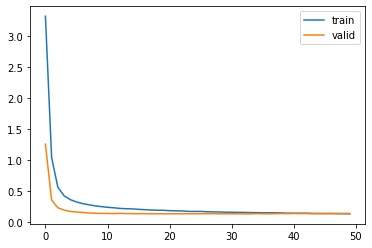

In [25]:
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.plot(tabsen_hist.history["loss"])
plt.plot(tabsen_hist.history["val_loss"])
plt.legend(['train','valid'])
# plt.xlim(100,500)
# plt.ylim(0.0,0.5)
plt.show()

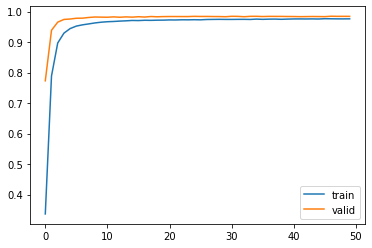

In [27]:
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.plot(tabsen_hist.history["acc"])
plt.plot(tabsen_hist.history["val_acc"])
plt.legend(['train','valid'])
# plt.xlim(100,500)
# plt.ylim(0.0,0.5)
plt.show()

In [23]:
tabsen.load_weights('../weight/attention/33-0.1379.hdf5')

# Evaluation

In [24]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

In [25]:
train_accuracy = print('train accuracy : {}'.format(evaluate(input_data=[x_train_, train_row_, train_proba], real=y_train_, model=tabsen)))
valid_accuracy = print('valid accuracy : {}'.format(evaluate(input_data=[x_valid_, valid_row_, valid_proba], real=y_valid_, model=tabsen)))
test_accuracy = print('test accuracy : {}'.format(evaluate(input_data=[x_test_, test_row_, test_proba], real=y_test_, model=tabsen)))

train accuracy : 0.9781867915343425
valid accuracy : 0.9832285115303984
test accuracy : 0.9840409207161125


In [40]:
def metric_score(real, input_data, model):
    pred_data = model.predict(input_data)
    pred_label = [np.argmax(i) for i in pred_data]
    real_label = [np.argmax(i) for i in real]
    
    score = precision_recall_fscore_support(real_label, pred_label)
    mean_score = [np.mean(i) for i in score[0:3]]
    
    return mean_score

In [41]:
precision, recall, fscore = metric_score(real=y_train_, input_data=[x_train_, train_row_, train_proba], model=tabsen)
print('precision : {}'.format(precision))
print('recall : {}'.format(recall))
print('fscore : {}'.format(fscore))

precision : 0.9663731787962756
recall : 0.9604724861055559
fscore : 0.9618698016864959


C:\Users\jeon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [42]:
precision, recall, fscore = metric_score(real=y_valid_, input_data=[x_valid_, valid_row_, valid_proba], model=tabsen)
print('precision : {}'.format(precision))
print('recall : {}'.format(recall))
print('fscore : {}'.format(fscore))

precision : 0.9617282679615882
recall : 0.9602516973049949
fscore : 0.959414724122534


In [43]:
precision, recall, fscore = metric_score(real=y_test_, input_data=[x_test_, test_row_, test_proba], model=tabsen)
print('precision : {}'.format(precision))
print('recall : {}'.format(recall))
print('fscore : {}'.format(fscore))

precision : 0.968243589866517
recall : 0.960829685199897
fscore : 0.9622844275427626


C:\Users\jeon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# 해석 모델

## variable_init

In [27]:
int_to_vocab[0] = 'pad'
int_to_vocab[1] = 'UNK'

In [50]:
import matplotlib
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/malgun.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()

In [51]:
init_x_dict = {}
init_x_dict['train'] = x_train_
init_x_dict['valid'] = x_valid_
init_x_dict['test'] = x_test_

In [52]:
init_y_dict = {}
init_y_dict['train'] = y_train_
init_y_dict['valid'] = y_valid_
init_y_dict['test'] = y_test_

In [53]:
split = 'test'

In [54]:
threshold=0.5

In [55]:
def hst_output(output):
    return [vecs2labels((line_output>threshold)*1, int_to_label) for line_output in output]

def vecs2labels(vecs, int_to_label):
    output = []
    for i, vec in enumerate(vecs):
        if vec == 1:
            output.append(int_to_label[i])
    return output    

## attention extract

In [61]:
label_to_int, int_to_label = bow_label(valid_class)
pred_attention = word_attention_extractor.predict(init_x_dict[split])
labels = [int_to_label[np.argmax(i)] for i in init_y_dict['test']]

In [ ]:
words_list = []
for sent_idx, sentence in enumerate(init_x_dict[split]):
    if sentence[0] == 0:
        continue

    for word_idx in range(max_len):
        if sentence[word_idx] == 0:
            words = [int_to_vocab[word_id] for word_id in sentence[0:word_idx]]
            pred_att = pred_attention[sent_idx][0:len(words)]
            pred_att = np.expand_dims(pred_att, axis=0)
            break
            
    fig, ax = plt.subplots(figsize=(len(words), 1))
    plt.rc('font', family=font_name)
    plt.rc('xtick', labelsize=12)
    midpoint = (max(pred_att[:, 0]) - min(pred_att[:, 0])) / 2
    heatmap = sn.heatmap(pred_att, xticklabels=words, yticklabels=False, square=True, linewidths=0.1, cmap='coolwarm', center=midpoint, vmin=0, vmax=1)
    words_list.append([np.array(pred_att[0]), words, labels[sent_idx]])
    
#     print(pred_att)
#     print(words)
#     print(labels[sent_idx])
#     print(line_dict[labels[sent_idx][0]])

    plt.xticks(rotation=45)
    plt.title(line_dict[labels[sent_idx][0]],)

    fig = plt.gcf()
    fig.savefig('./output_png/200128/word_attention_{}_{}'.format(split,sent_idx), bbox_inches = "tight")
    fig = plt.figure()
    fig.patch.set_facecolor('xkcd:white')
    plt.show()
    print('*************************************************')
    print('\n\n\n\n\n')

In [81]:
scores = [i[0] for i in words_list]
tokens = [i[1] for i in words_list]

In [ ]:
for sen_idx, (score,token) in enumerate(zip(scores, tokens)) :
    for tok_idx, (s,t) in enumerate(zip(score, token)) :
        print(t, ':', s)
    df = pd.DataFrame(score,token).T
    df.to_excel('./output_excel/0121_answer/output_{}_{}.xlsx'.format(split, sen_idx))
    print('\n\n')

# Count Per Label

In [40]:
def int_to_label(y_vectors, valid_class):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(valid_class.reshape(-1,1))
    labels = enc.inverse_transform(y_vectors)
    return labels

In [41]:
def count_per_label(input_data, real, seg, output):
    pred = tabsen.predict(input_data)
    pred_label = [line_dict[i] for i in np.concatenate(int_to_label(pred, valid_class))]
    real_label = [line_dict[i] for i in np.concatenate(int_to_label(real, valid_class))]
    accuracy = [[pred==real, real] for pred, real in zip(pred_label, real_label)]
    
    count_real_label = pd.DataFrame([i for i in Counter(real_label).items()])
    count_real_label.columns = ['label','count']

    accuracy = pd.DataFrame(accuracy).groupby([1]).mean().reset_index()
    accuracy.columns = ['label', 'accuracy']
    
    df = pd.merge(count_real_label, accuracy)
    
    if output==True :    
        df.to_excel('./result/output_result_{}.xlsx'.format(seg))
    
    return df

In [42]:
line_index = pd.read_excel('../data/index_line_label.xlsx', header=None)
line_dict = {}
for i in line_index.values:
#     print(i[1])
    line_dict[i[1]] = i[0]
line_dict['-'] = '-'    

In [43]:
train_df = count_per_label(input_data=[x_train_, train_row_, train_proba], real=y_train_, seg='train', output=True)
valid_df = count_per_label(input_data=[x_valid_, valid_row_, valid_proba], real=y_valid_, seg='valid', output=True)
test_df = count_per_label(input_data=[x_test_, test_row_, test_proba], real=y_test_, seg='test', output=True)

In [67]:
def count_data(input_data, real, seg, output):
    pred = tabsen.predict(input_data)
    pred_label = [line_dict[i] for i in np.concatenate(int_to_label(pred, valid_class))]
    real_label = [line_dict[i] for i in np.concatenate(int_to_label(real, valid_class))]
    accuracy = [[pred==real, real] for pred, real in zip(pred_label, real_label)]
    
    count_real_label = pd.DataFrame([i for i in Counter(real_label).items()])
    count_real_label.columns = ['label',seg]

    return count_real_label

In [68]:
train_count_df = count_data(input_data=[x_train_, train_row_, train_proba], real=y_train_, seg='train', output=True)
valid_count_df = count_data(input_data=[x_valid_, valid_row_, valid_proba], real=y_valid_, seg='valid', output=True)
test_count_df = count_data(input_data=[x_test_, test_row_, test_proba], real=y_test_, seg='test', output=True)

In [78]:
all_count_df = pd.merge(pd.merge(train_count_df, valid_count_df, on='label', how='outer'), test_count_df, on='label', how='outer').to_excel('./result/output_all_count.xlsx')